# Problem
The objective was to analyze customer behavior and segment them into different groups based on their characteristics, so that marketing strategies could be tailored to each group.

# Data Collection
The data for this project was sourced from Customer Personality Analysis on Kaggle by Akash Patel.
https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis

In [1]:
# Data manipulation 
import pandas as pd
import numpy as np
import datetime

# Visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.decomposition import PCA
from pylab import rcParams

# Machine learning package 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score


%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 27

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
sns.set_palette(sns.color_palette("pastel"))
rcParams['figure.figsize'] = 12, 8

import warnings
warnings.filterwarnings("ignore")

## Customer
- ID: Customer's unique identifier
- Year_Birth: Customer's birth year
- Education: Customer's education level
- Marital_Status: Customer's marital status
- Income: Customer's yearly household income
- Kidhome: Number of children in customer's household
- Teenhome: Number of teenagers in customer's household
- Dt_Customer: Date of customer's enrollment with the company
- Recency: Number of days since customer's last purchase
- Complain: 1 if the customer complained in the last 2 years, 0 otherwise

## Product
- MntWines: Amount spent on wine in last 2 years
- MntFruits: Amount spent on fruits in last 2 years
- MntMeatProducts: Amount spent on meat in last 2 years
- MntFishProducts: Amount spent on fish in last 2 years
- MntSweetProducts: Amount spent on sweets in last 2 years
- MntGoldProds: Amount spent on gold in last 2 years

## Promotion
- NumDealsPurchases: Number of purchases made with a discount
- AcceptedCmp1: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
- AcceptedCmp2: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
- AcceptedCmp3: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
- AcceptedCmp4: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
- AcceptedCmp5: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
- Response: 1 if customer accepted the offer in the last campaign, 0 otherwise

## Place
- NumWebPurchases: Number of purchases made through the company’s website
- NumCatalogPurchases: Number of purchases made using a catalogue
- NumStorePurchases: Number of purchases made directly in stores
- NumWebVisitsMonth: Number of visits to company’s website in the last month


# Loading Data

In [2]:
data = pd.read_csv("marketing_campaign.csv", sep="\t")

In [3]:
print(data.shape)
data.head()

(2240, 29)


ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Obeservation:
- There are missing values in Income
- Dt_Customer is incorrect data type
- There is categorical data that Need to label Education (Ordinal) Marital_Status (Group)

## Missing data

In [5]:
data.dropna(inplace=True) #drop missing value

In [6]:
data.Dt_Customer = pd.to_datetime(data.Dt_Customer, dayfirst=True) #change Dt_Customer data type to datetime

In [7]:
data.Education.unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

In [8]:
print(data.groupby("Marital_Status")["ID"].count())
print("-"*30, "\n" ,data.groupby("Education")["ID"].count())


Marital_Status
Absurd        2
Alone         3
Divorced    232
Married     857
Single      471
Together    573
Widow        76
YOLO          2
Name: ID, dtype: int64
------------------------------ 
 Education
2n Cycle       200
Basic           54
Graduation    1116
Master         365
PhD            481
Name: ID, dtype: int64


# Feature engineer 
- Encoder Education
- Group Marital_Status into single and non-single 
- Age feature: 2022 - Birthday (The data published on 20 Feb 2022)
- Convert Dt_Customer to the customerFor (days)
- Total Spending

In [9]:
education_label = {"Basic": 0, "Graduation": 1, "2n Cycle": 2, "Master": 2, "PhD": 3}
data.Education = data.Education.replace(education_label) # Ordinal encoder on Education

In [10]:
data.Marital_Status.unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

In [11]:
marital_label = {'Single': 1, 'Together':0, 'Married':0, 'Divorced':1, 'Widow':1, 'Alone':1, 'Absurd':1, 'YOLO':1}
data.Marital_Status = data.Marital_Status.replace(marital_label) # Ordinal encoder on Education

In [12]:
data["Age"] = 2022 - data.Year_Birth

In [13]:
def date_diff(df):
    a = df
    b = datetime.datetime(2022, 2, 20)
    c = b-a
    return c.days
    
data["CustomerFor"] = data.Dt_Customer.apply(date_diff)

In [14]:
to_drop = ["Year_Birth", "ID", "Z_CostContact", "Z_Revenue", "Dt_Customer"]
data.drop(to_drop, axis=1, inplace=True)

In [15]:
#Change column names for better visualsize
data=data.rename(columns={"MntWines": "Wines",
                          "MntFruits":"Fruits",
                          "MntMeatProducts":"Meat",
                          "MntFishProducts":"Fish",
                          "MntSweetProducts":"Sweets",
                          "MntGoldProds":"Gold",
                          "Marital_Status":"Single"})

In [16]:
data

Education  Single   Income  Kidhome  Teenhome  Recency  Wines  Fruits  \
0             1       1  58138.0        0         0       58    635      88   
1             1       1  46344.0        1         1       38     11       1   
2             1       0  71613.0        0         0       26    426      49   
3             1       0  26646.0        1         0       26     11       4   
4             3       0  58293.0        1         0       94    173      43   
...         ...     ...      ...      ...       ...      ...    ...     ...   
2235          1       0  61223.0        0         1       46    709      43   
2236          3       0  64014.0        2         1       56    406       0   
2237          1       1  56981.0        0         0       91    908      48   
2238          2       0  69245.0        0         1        8    428      30   
2239          3       0  52869.0        1         1       40     84       3   

      Meat  Fish  ...  NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  \
0      546   172  ...                  7             0             0   
1        6     2  ...                  5             0             0   
2      127   111  ...                  4             0             0   
3       20    10  ...                  6             0             0   
4      118    46  ...                  5             0             0   
...    ...   ...  ...                ...           ...           ...   
2235   182    42  ...                  5             0             0   
2236    30     0  ...                  7             0             0   
2237   217    32  ...                  6             0             1   
2238   214    80  ...                  3             0             0   
2239    61     2  ...                  7             0             0   

      AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Response  Age  \
0                0             0             0         0         1   65   
1                0             0             0         0         0   68   
2                0             0             0         0         0   57   
3                0             0             0         0         0   38   
4                0             0             0         0         0   41   
...            ...           ...           ...       ...       ...  ...   
2235             0             0             0         0         0   55   
2236             0             1             0         0         0   76   
2237             0             0             0         0         0   41   
2238             0             0             0         0         0   66   
2239             0             0             0         0         1   68   

      CustomerFor  
0            3456  
1            2906  
2            3105  
3            2932  
4            2954  
...           ...  
2235         3174  
2236         2812  
2237         2948  
2238         2949  
2239         3415  

[2216 rows x 26 columns]

In [17]:
data["total_spend"] = data.Wines+data.Fruits+data.Meat+data.Fish+data.Sweets+data.Gold
data["family_size"] = data.Kidhome + data.Teenhome + np.where(data.Single == 1, 1, 2) 
data["is_parent"] = np.where( data.Kidhome + data.Teenhome > 0, 1, 0)

## Outliers

In [18]:
def remove_outliers(data, categorical_columns, threshold=3):
    cleaned_data = data.copy()
    before = cleaned_data.shape[0]

    continuous_data = cleaned_data.drop(categorical_columns, axis=1)
    z = (continuous_data - continuous_data.mean()) / continuous_data.std()

    mask = (z.abs() > threshold).any(axis=1)

    cleaned_data = cleaned_data[~mask]
    after = cleaned_data.shape[0]
    print("Amount of outliers: ", before-after)
    return cleaned_data
cate_col = ["Complain", "AcceptedCmp1", "AcceptedCmp2", "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "Response","Single", "is_parent"]
data = remove_outliers(data, cate_col)

Amount of outliers:  264


# EDA

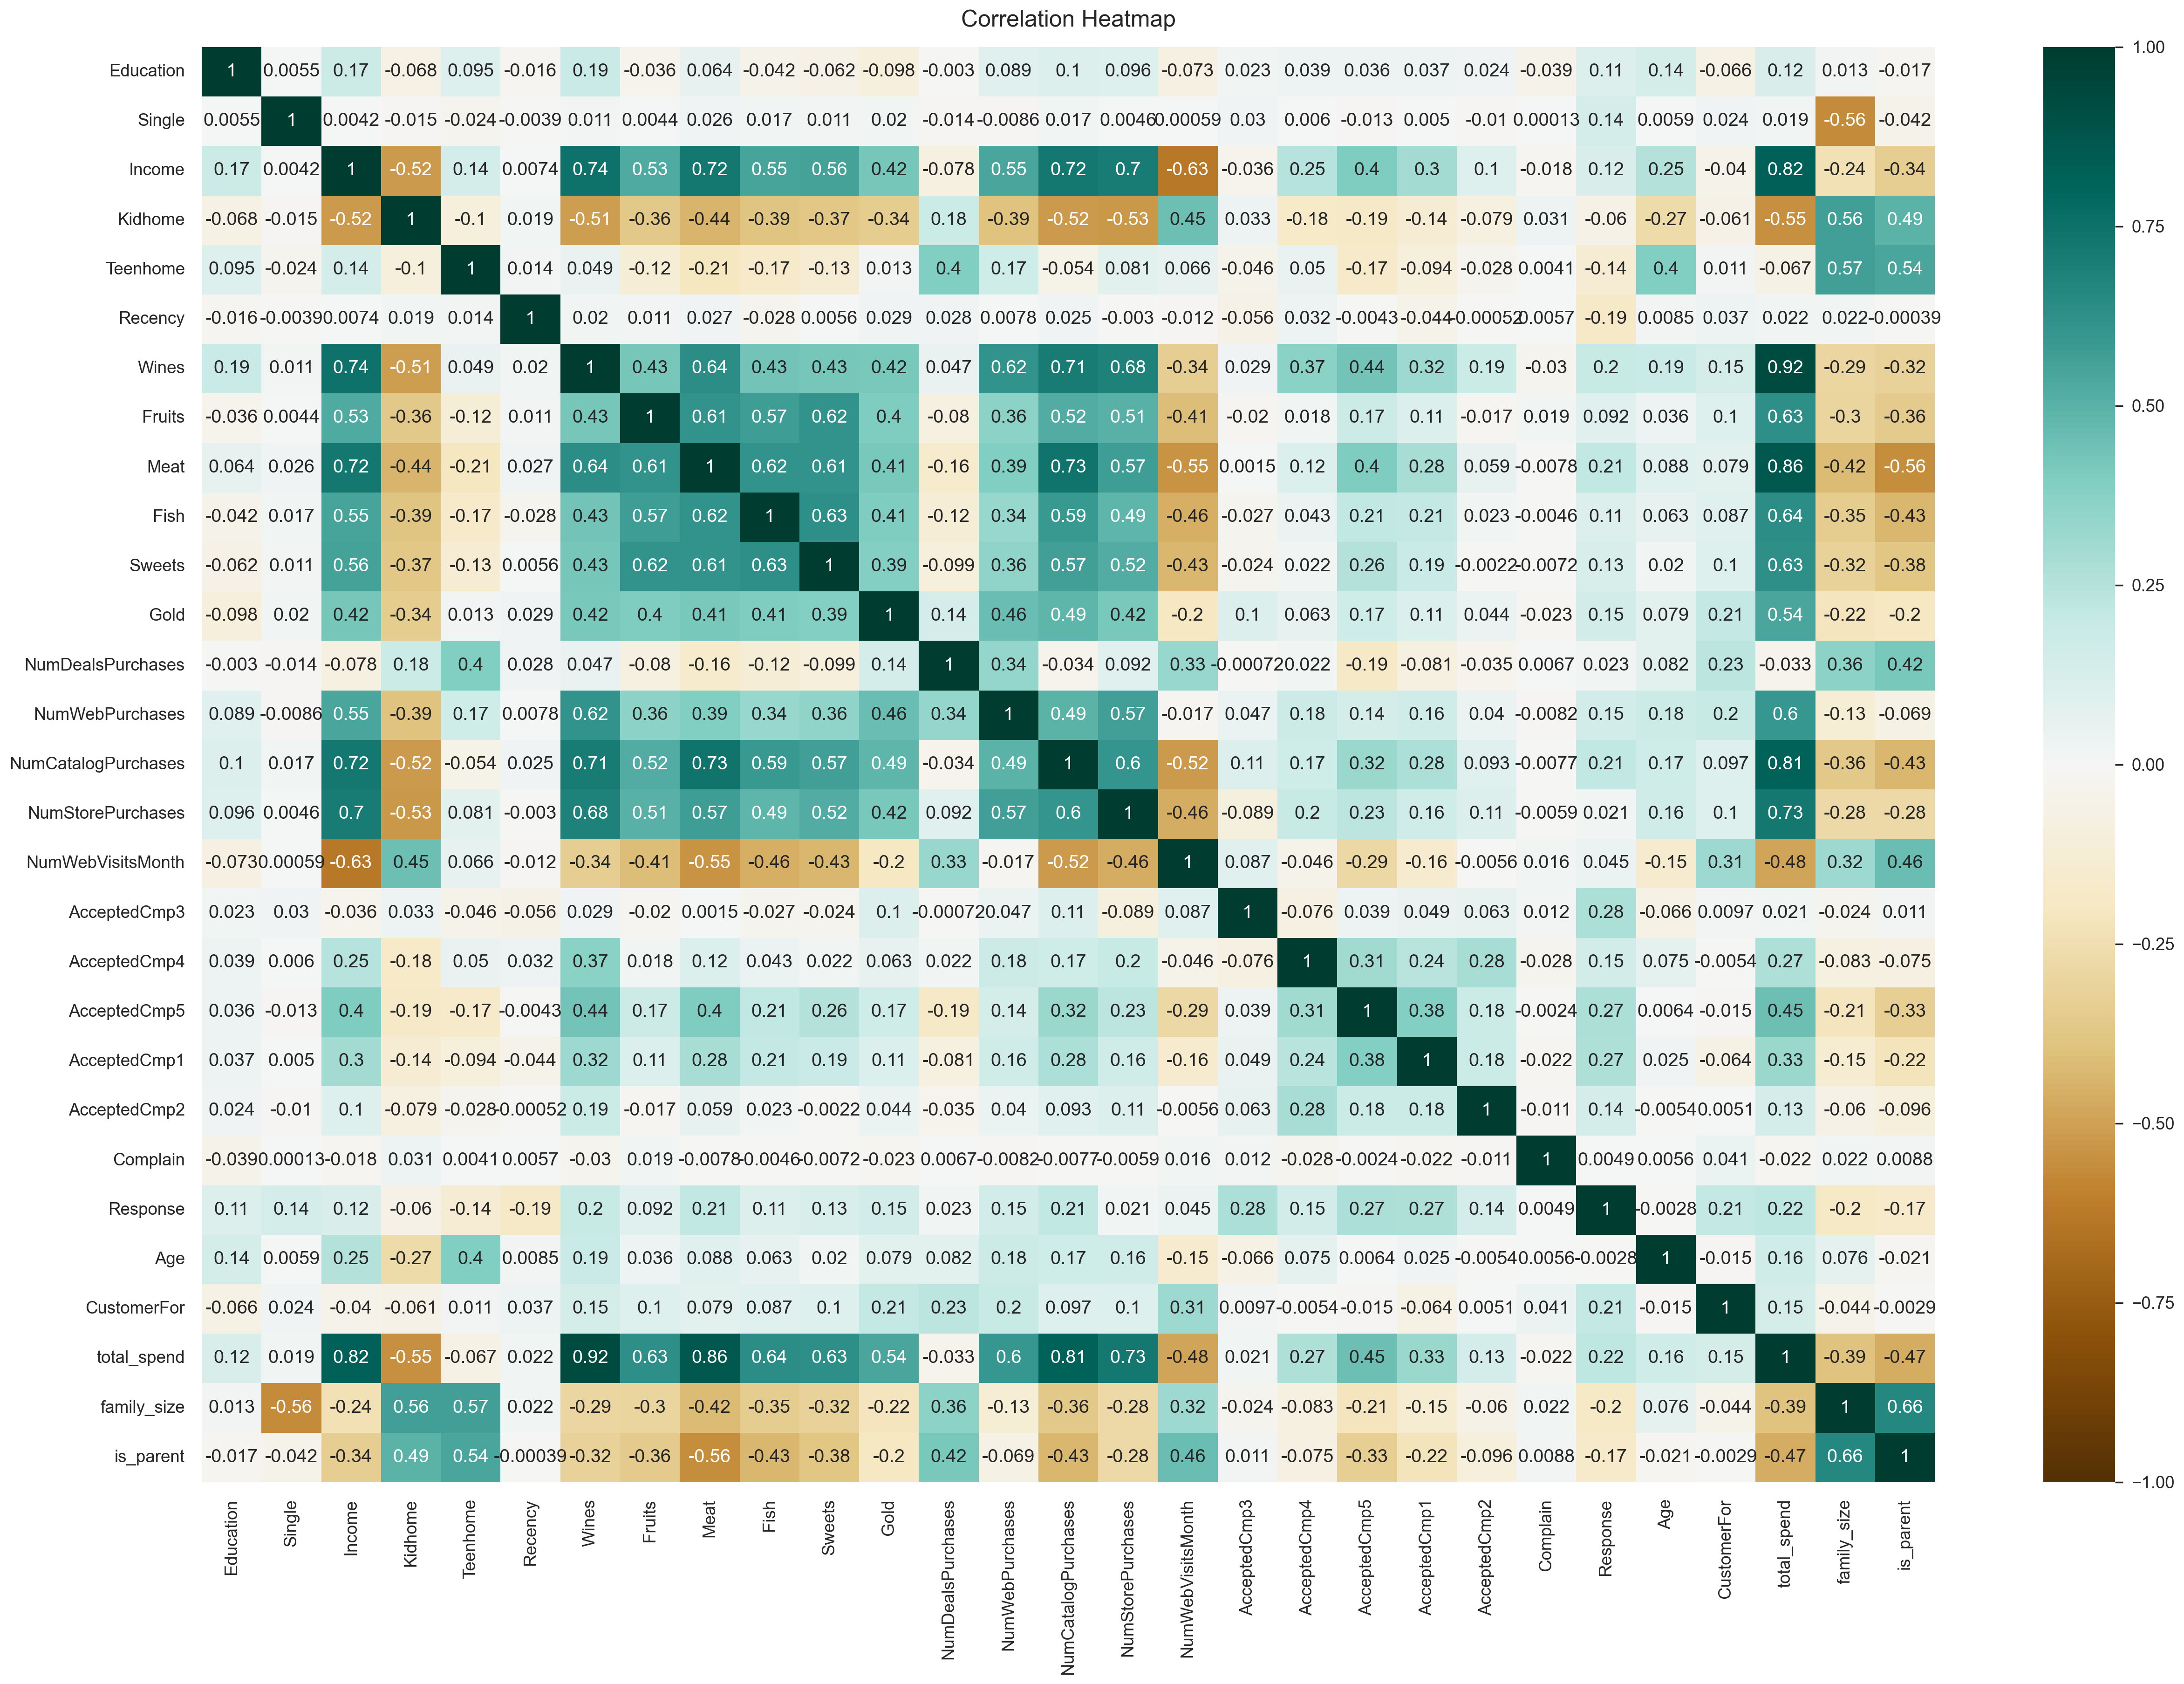

In [19]:
plt.figure(figsize=(30, 20))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

Key Observation:
1. NumCatelogPurchase and Meat have a strong correlation -> customer trend to buy meat via Catalog
2. Customers tend to purchase wine from all platforms without visiting the website
3. Customers who have kids tend to make fewer purchases, but they visit more website
4. Drop features that are highly correlated to each other. In this case, we choose to keep Income and drop other highly correlated feature 

## High Correlated data

In [20]:
to_drop = ["Wines", "Meat", "NumCatalogPurchases", "NumStorePurchases", "NumWebVisitsMonth", "Kidhome", "total_spend", "family_size", 
          'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response'] 
#drop marketing realted due to foucs on custoemr behavior
data2 = data.drop(to_drop, axis=1)

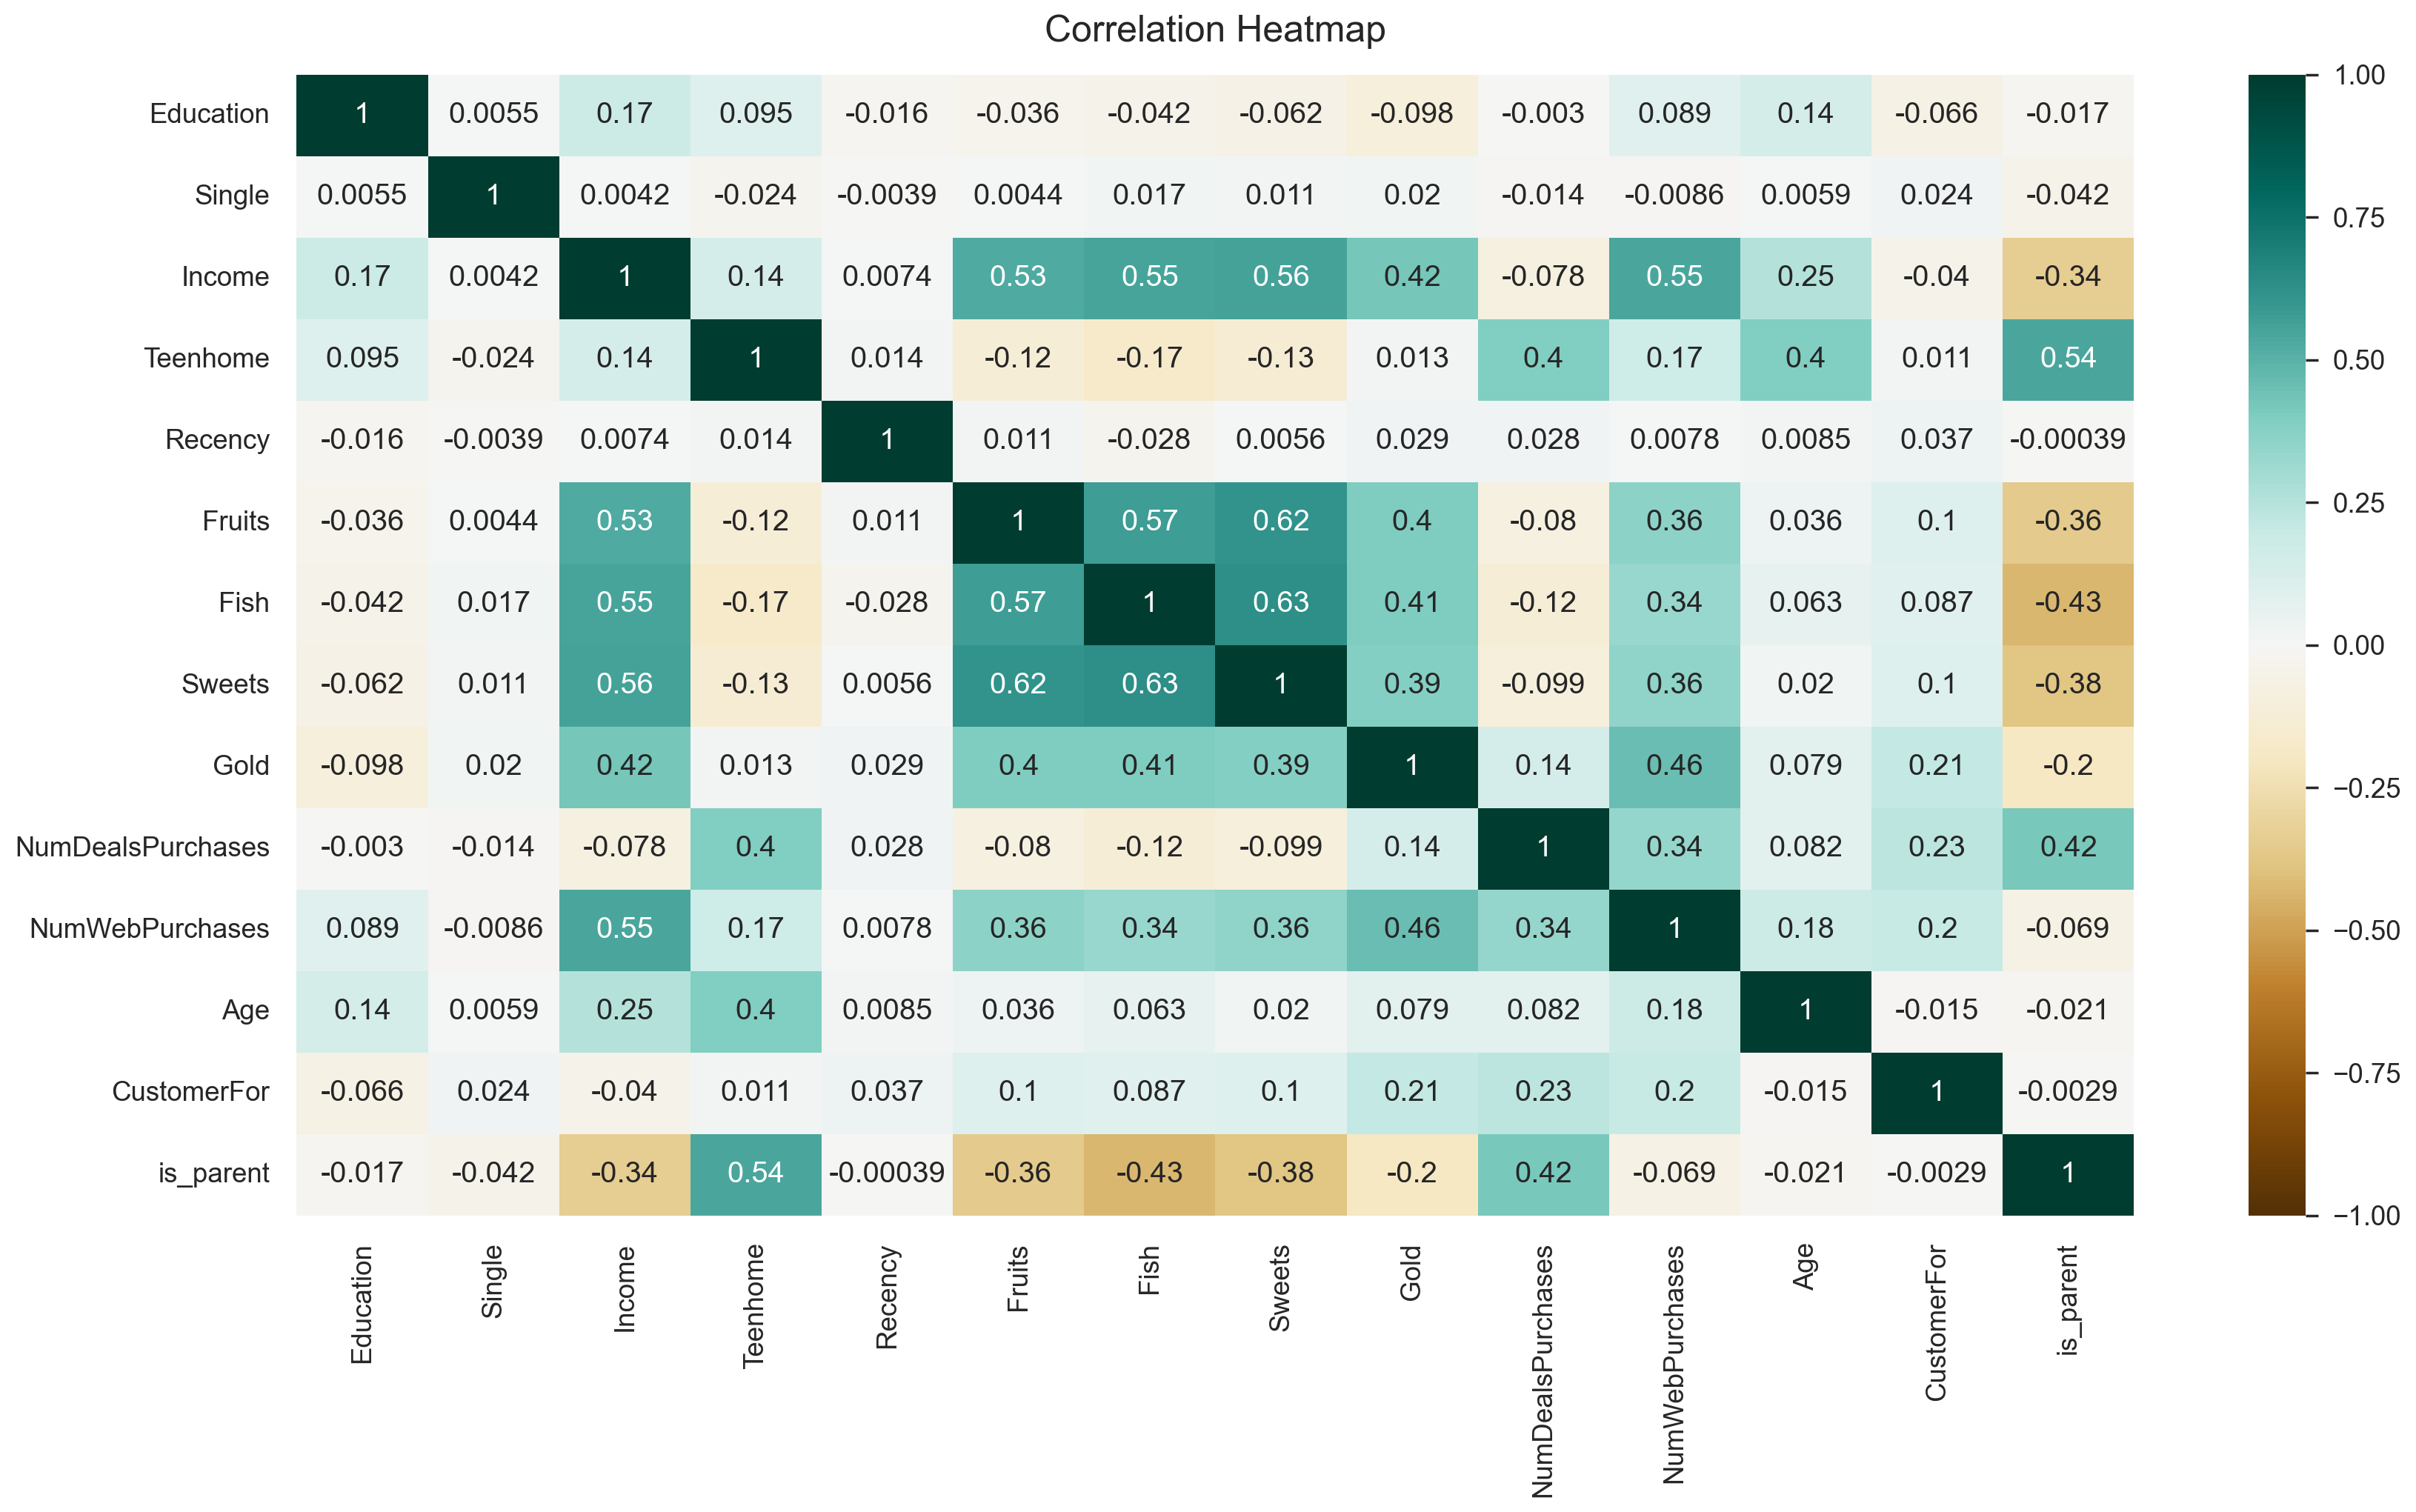

In [21]:
plt.figure(figsize=(20, 10))
heatmap = sns.heatmap(data2.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

# Data preprocessing

In [22]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1952 entries, 0 to 2239
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Education          1952 non-null   int64  
 1   Single             1952 non-null   int64  
 2   Income             1952 non-null   float64
 3   Teenhome           1952 non-null   int64  
 4   Recency            1952 non-null   int64  
 5   Fruits             1952 non-null   int64  
 6   Fish               1952 non-null   int64  
 7   Sweets             1952 non-null   int64  
 8   Gold               1952 non-null   int64  
 9   NumDealsPurchases  1952 non-null   int64  
 10  NumWebPurchases    1952 non-null   int64  
 11  Age                1952 non-null   int64  
 12  CustomerFor        1952 non-null   int64  
 13  is_parent          1952 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 228.8 KB


In [23]:
scaler = StandardScaler().fit(data2)
data_scaled = pd.DataFrame(scaler.transform(data2),columns= data2.columns)

In [24]:
data_scaled.head()

Education    Single    Income  Teenhome   Recency    Fruits      Fish  \
0  -0.800190  1.364614  0.457897 -0.973627  0.305899  2.310292  3.416619   
1  -0.800190  1.364614 -0.144515  0.869748 -0.384447 -0.633348 -0.633923   
2  -0.800190 -0.732808  1.146171 -0.973627 -0.798655  0.990729  1.963190   
3  -0.800190 -0.732808 -1.150646 -0.973627 -0.798655 -0.531843 -0.443309   
4   1.553949 -0.732808  0.465814 -0.973627  1.548523  0.787720  0.414453   

     Sweets      Gold  NumDealsPurchases  NumWebPurchases       Age  \
0  2.206171  1.194225           0.444687         1.563647  1.032331   
1 -0.631803 -0.727542          -0.187066        -1.113756  1.290613   
2  0.020605  0.116160          -0.818820         1.563647  0.343581   
3 -0.566562 -0.750979          -0.187066        -0.731270 -1.292200   
4  0.216327 -0.516617           1.708194         0.416189 -1.033919   

   CustomerFor  is_parent  
0     1.559330  -1.795859  
1    -1.174970   0.556837  
2    -0.185650  -1.795859  
3    -1.045712   0.556837  
4    -0.936340   0.556837

# Data in 3D plot

In [25]:
pca = PCA(n_components=3)
pca.fit(data_scaled)
PCA_df = pd.DataFrame(pca.transform(data_scaled), columns=(["col1","col2", "col3"]))
PCA_df.describe().T

count          mean       std       min       25%       50%      75%  \
col1  1952.0  7.280151e-18  1.917697 -2.483565 -1.586426 -0.649315  1.24117   
col2  1952.0 -1.456030e-17  1.479735 -3.280862 -1.294096 -0.085684  1.18059   
col3  1952.0  2.821059e-17  1.177759 -3.202487 -0.808029  0.018843  0.77636   

           max  
col1  7.256123  
col2  5.264055  
col3  3.702046

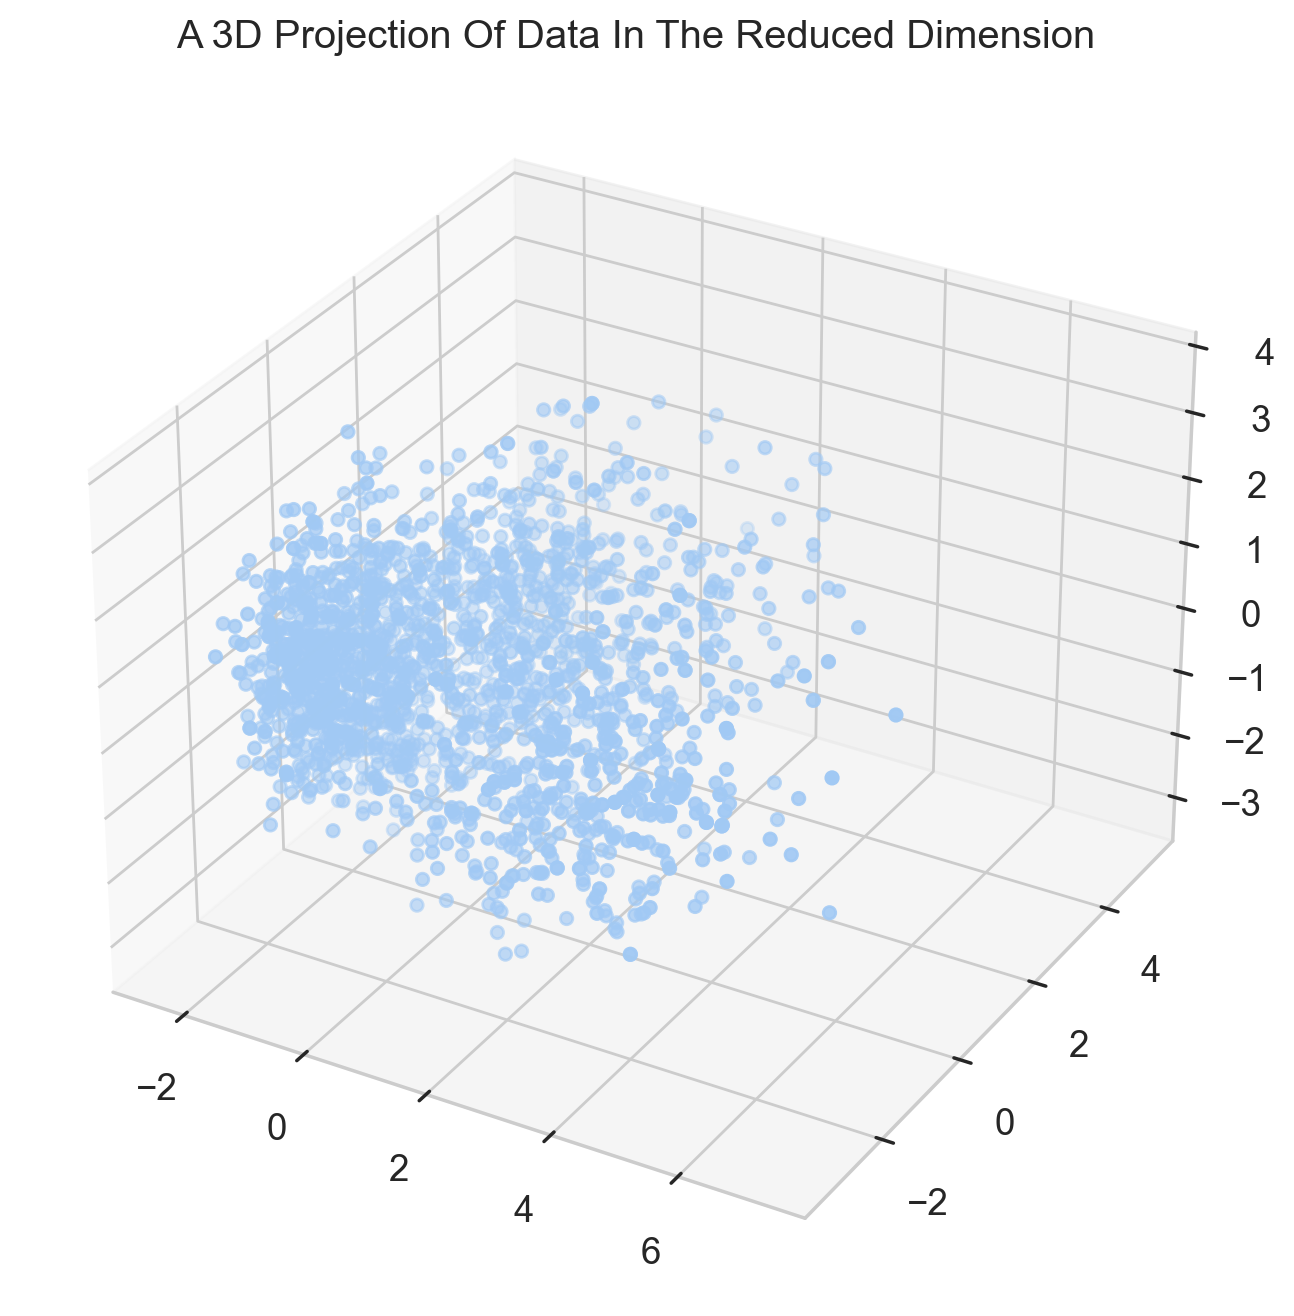

In [26]:
x =PCA_df["col1"]
y =PCA_df["col2"]
z =PCA_df["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, marker="o")
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

# Model

In [27]:
silhouette_scores = []
for x in range(2,11):
    model = KMeans(n_clusters = x, random_state=RANDOM_SEED)
    model.fit(data_scaled)
    silhouette_scores.append(silhouette_score(data_scaled, model.labels_))

plt.bar(range(2,11), silhouette_scores)    
plt.xlabel('Number of clusters', fontsize = 20)
plt.ylabel('S(i)', fontsize = 20)
plt.show()

In [28]:
Elbow_M = KElbowVisualizer(KMeans(random_state=RANDOM_SEED), k=10)
Elbow_M.fit(data_scaled)
Elbow_M.show()

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [29]:
num_c = 5

In [30]:
kmeans = KMeans(n_clusters=num_c, random_state=RANDOM_SEED)
kmeans.fit(data_scaled)
np.unique(kmeans.labels_)

array([0, 1, 2, 3, 4], dtype=int32)

In [31]:
PCA_df["Clusters"] = kmeans.labels_
PCA_df

col1      col2      col3  Clusters
0     5.171269 -0.242231  1.412310         4
1    -1.641888  0.254694 -1.226767         2
2     2.865601 -1.133861 -0.307453         4
3    -1.872507 -1.486897  0.610349         1
4     0.410513  0.354493 -0.062676         3
...        ...       ...       ...       ...
1947 -1.666357 -1.359658  0.641000         1
1948 -0.622658  3.342523 -2.033981         3
1949  0.643611 -2.452901  0.076553         4
1950  1.415327  1.165885 -1.547976         0
1951 -0.959309  1.634248 -0.918516         2

[1952 rows x 4 columns]

In [32]:
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")

for i in np.unique(kmeans.labels_):
    x =PCA_df[PCA_df.Clusters == i]["col1"]
    y =PCA_df[PCA_df.Clusters == i]["col2"]
    z =PCA_df[PCA_df.Clusters == i]["col3"]
    ax.scatter(x, y, z, label = i)
    
ax.legend()
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

# Analyze

In [33]:
data["Clusters"] = kmeans.labels_

## Income and Spending 

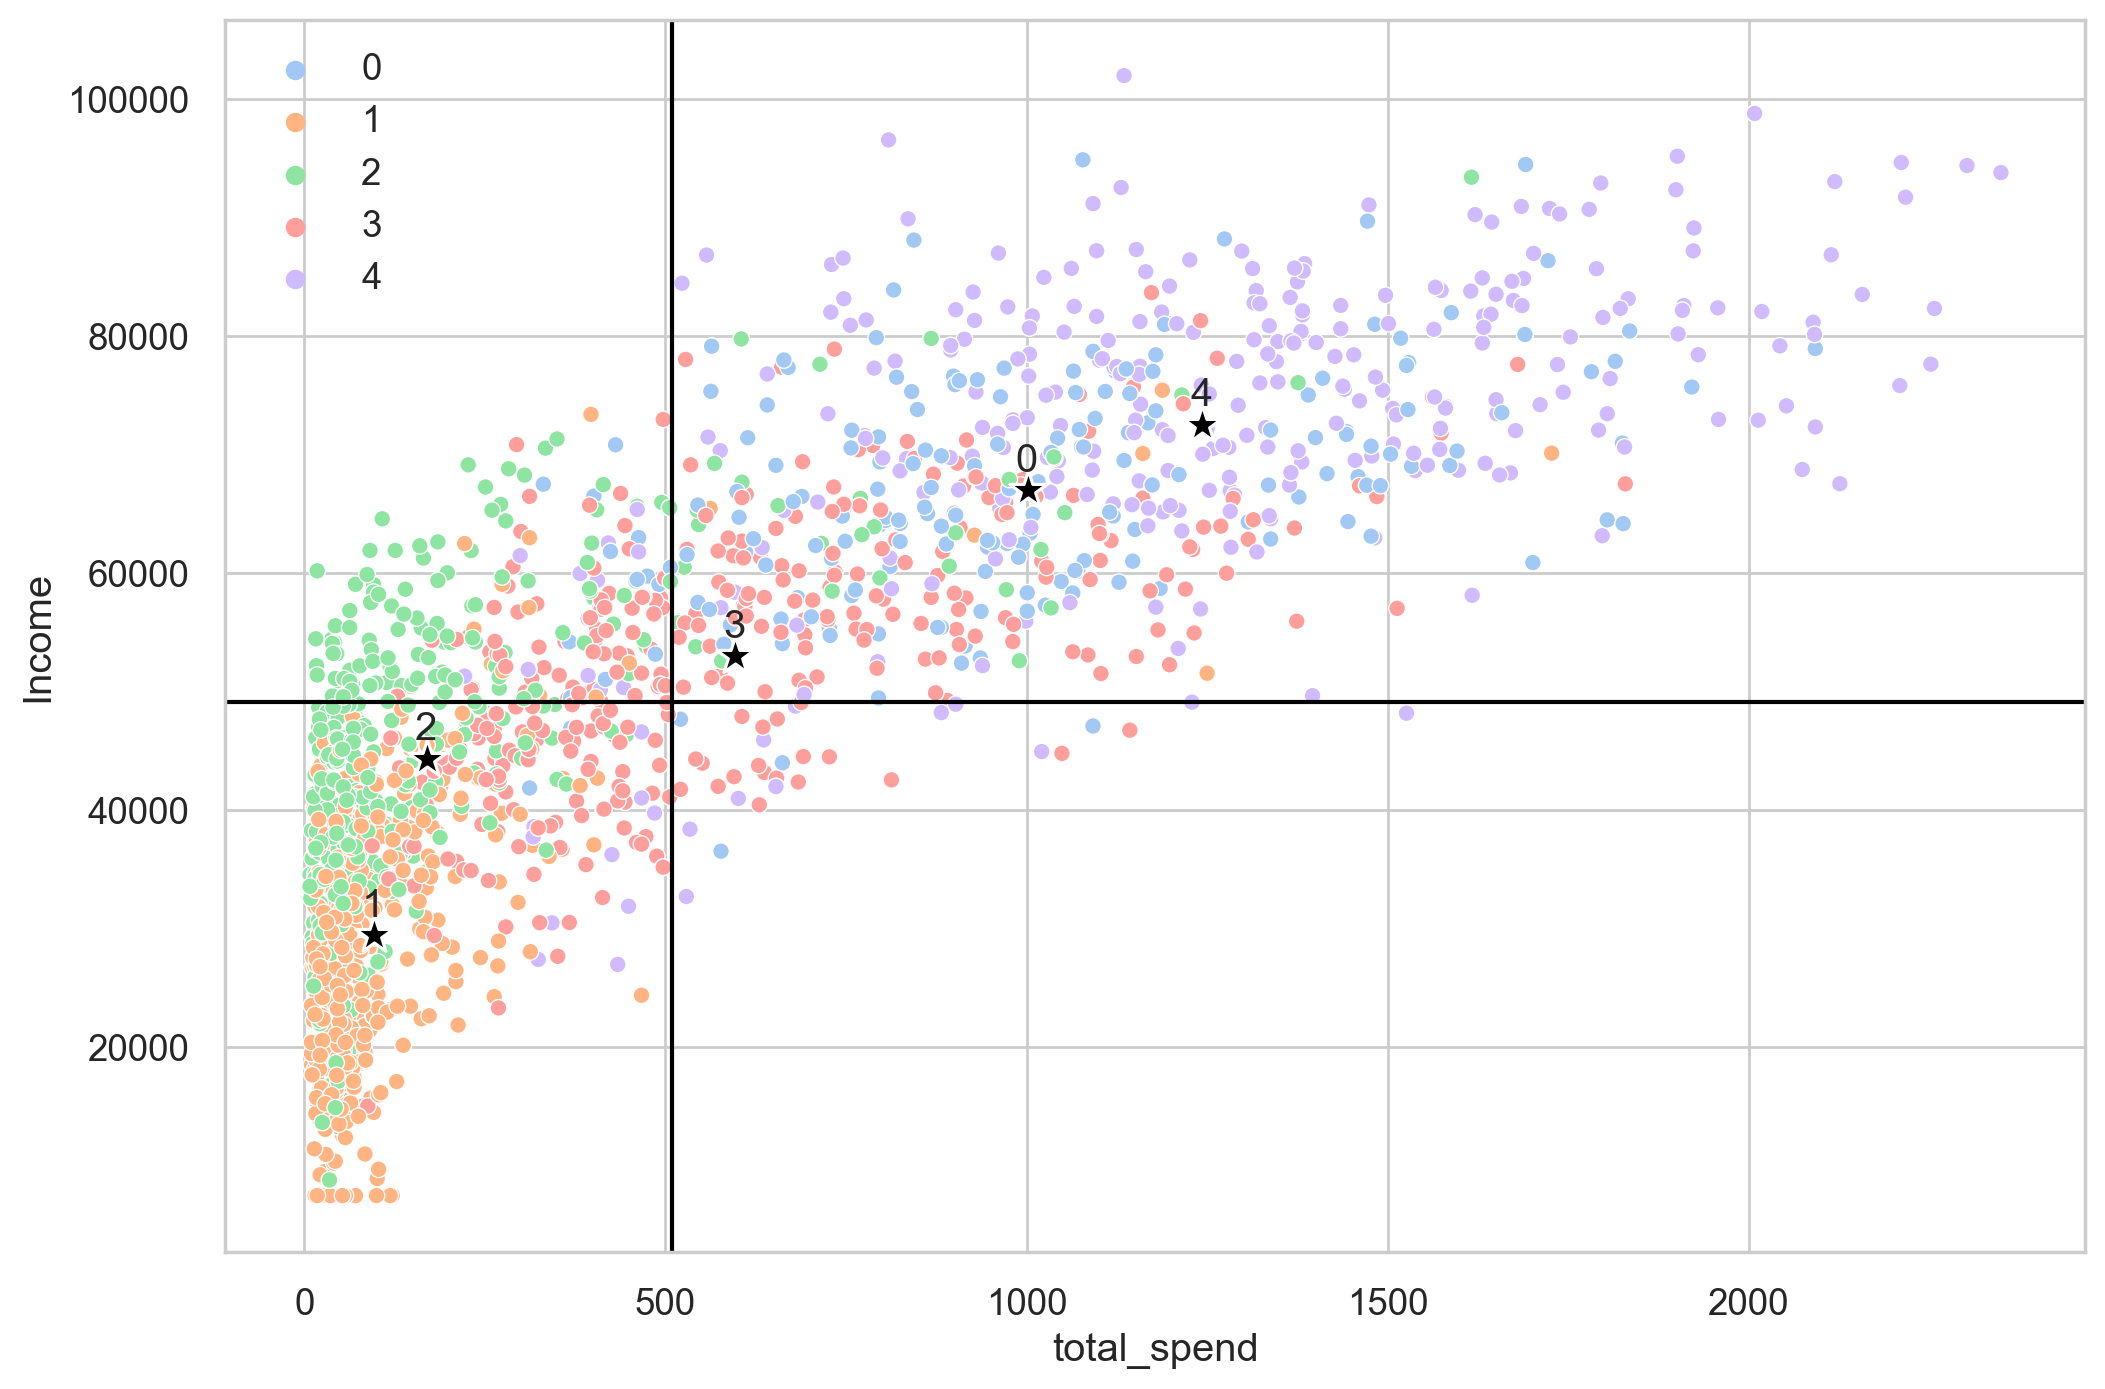

In [35]:
graph = sns.scatterplot(x=data.total_spend, y=data.Income, hue=data.Clusters, palette='pastel')
graph.axhline(data.Income.mean(), color="Black")
graph.axvline(data.total_spend.mean(), color="Black")
for i in data.Clusters.unique():
    x = np.array([data[data.Clusters == i ]["total_spend"].mean()])
    y = np.array([data[data.Clusters == i ]["Income"].mean()])
    sns.scatterplot(x=x, y=y, color="Black", marker="*", s=200)
    plt.text(x-17,y+1600,i)
    
plt.legend()
plt.show()

## Speding on each cluster

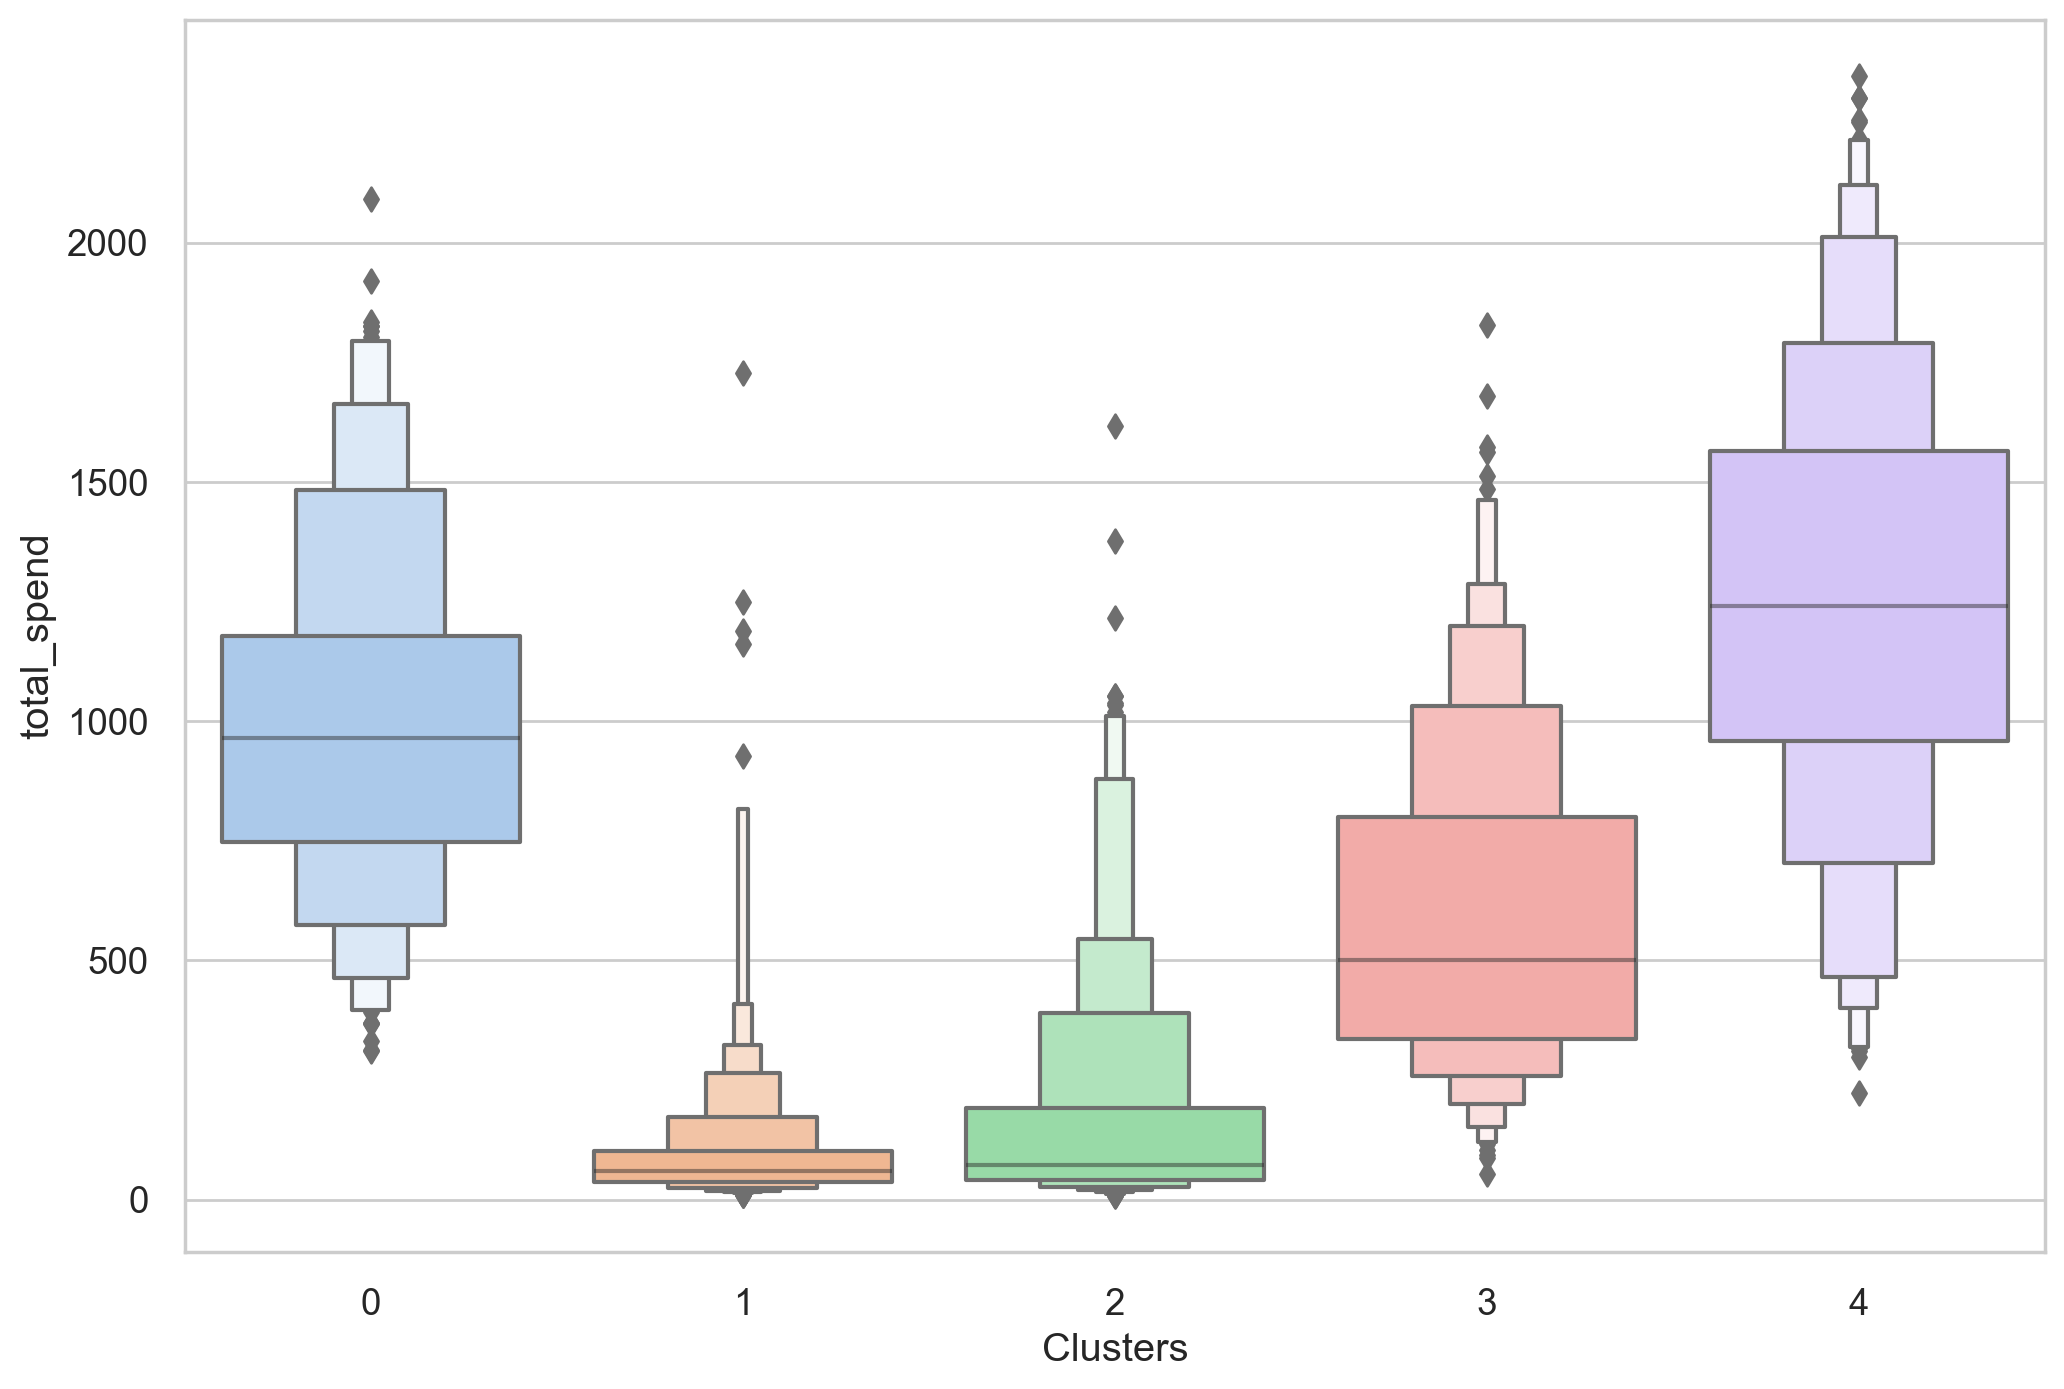

In [36]:
sns.boxenplot(x=data["Clusters"], y=data.total_spend)
plt.show()

## Deal Purchases on each Cluster

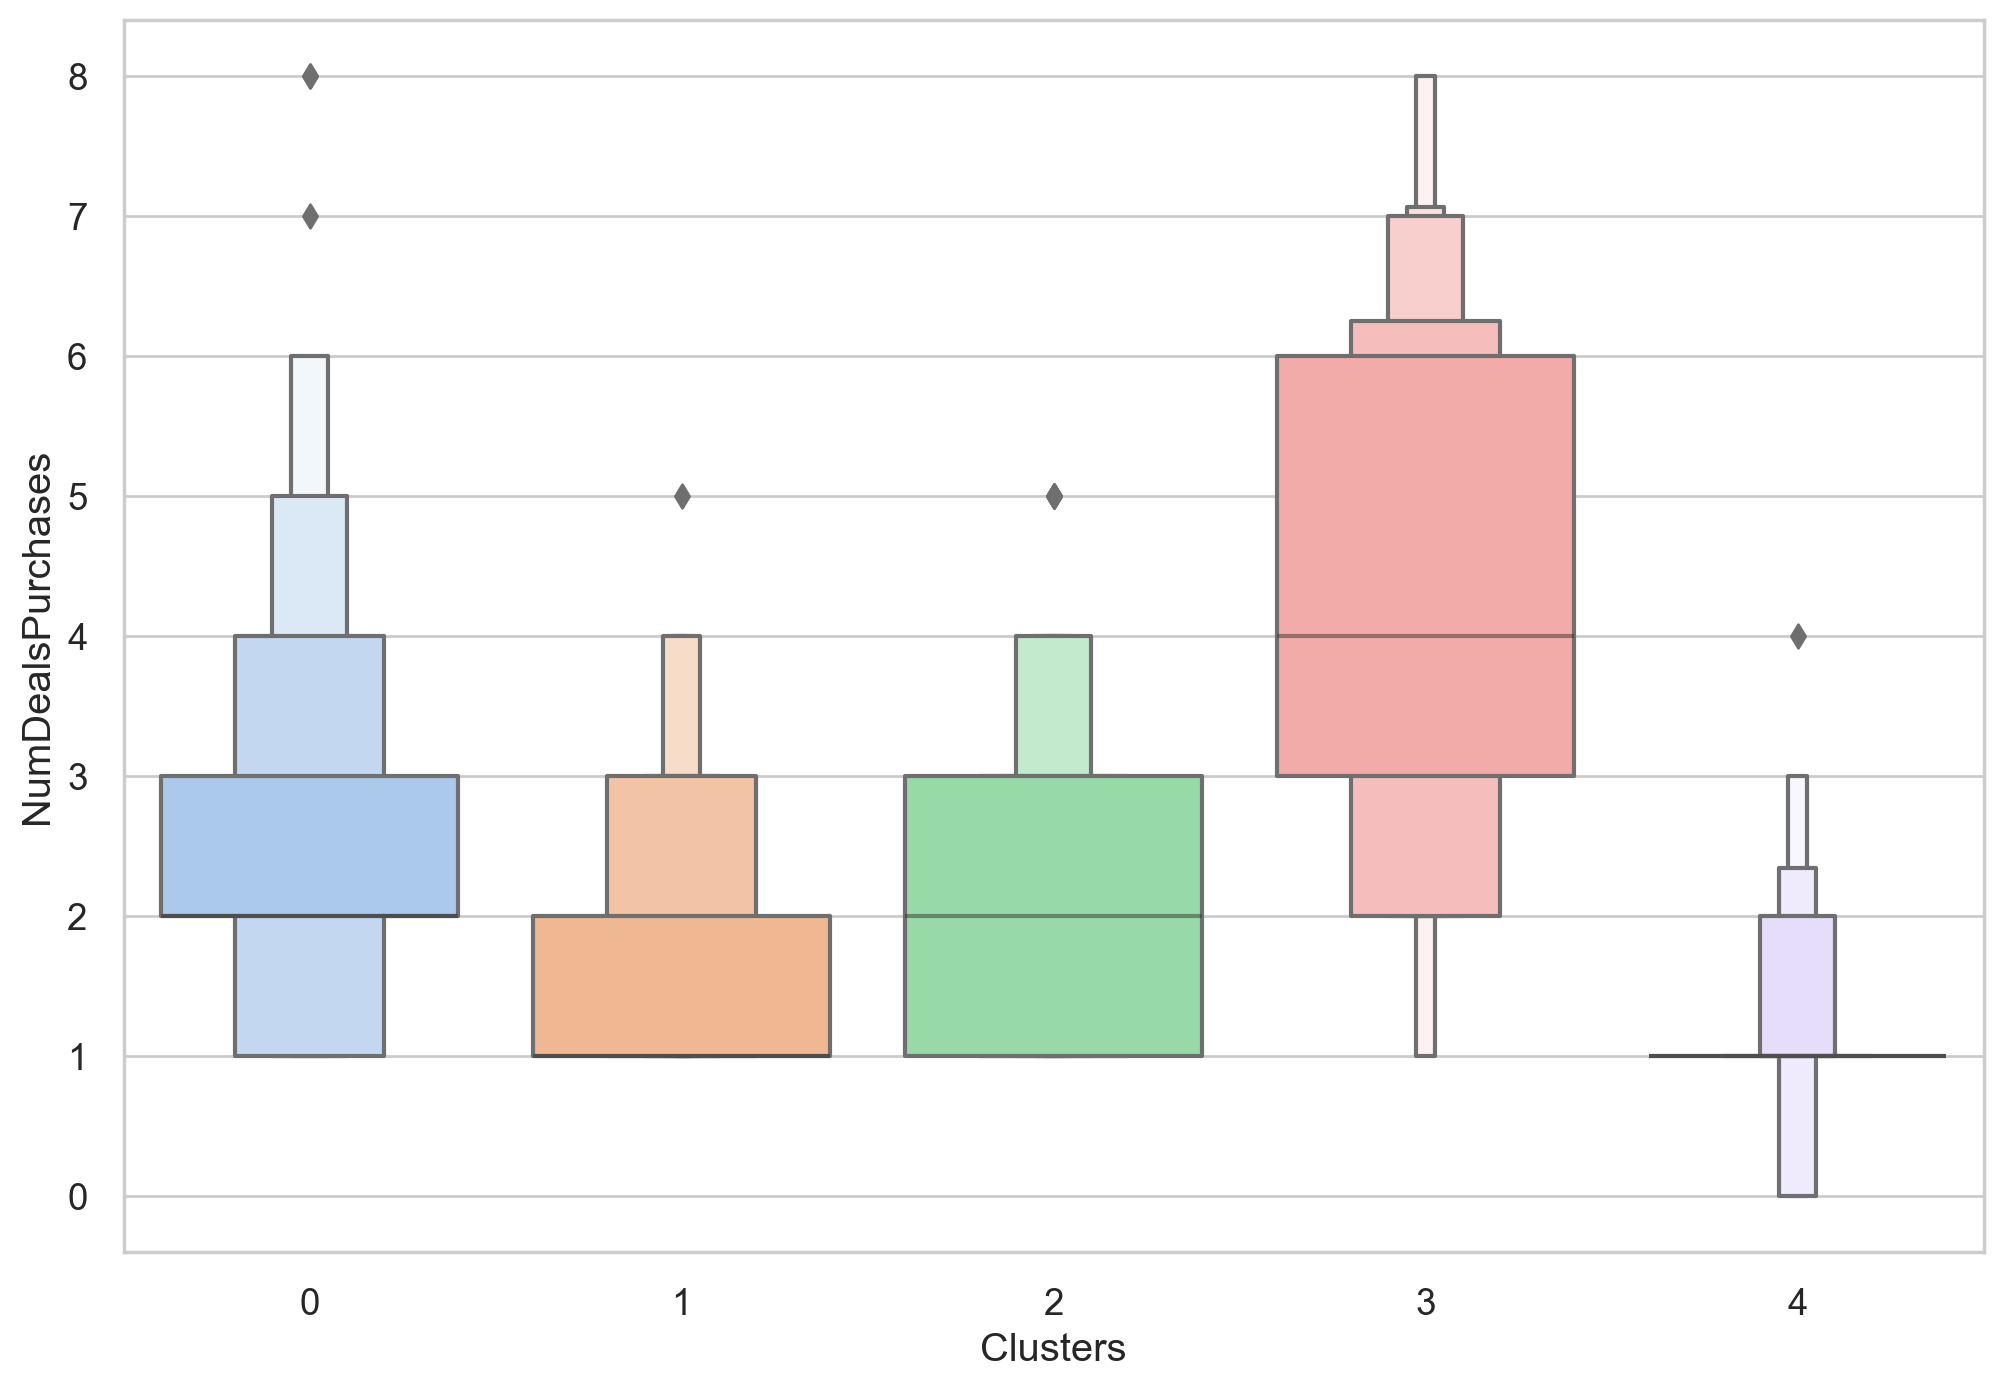

In [38]:
sns.boxenplot(x=data["Clusters"], y=data.NumDealsPurchases)
plt.show()

## Customer Demography

In [47]:
def dominant_cluster(df, feature_col, cluster_label_col, target_cluster, threshold=1.00):
    filtered_df = df[df[cluster_label_col] == target_cluster]
    df2 = filtered_df[feature_col]
    total = len(filtered_df[feature_col])
    for x in df2.unique(): 
        if df2[df2==x].count() >= total*threshold:
            print(f"Cluster {target_cluster} dominated by {x} values")

<Figure size 1200x800 with 0 Axes>

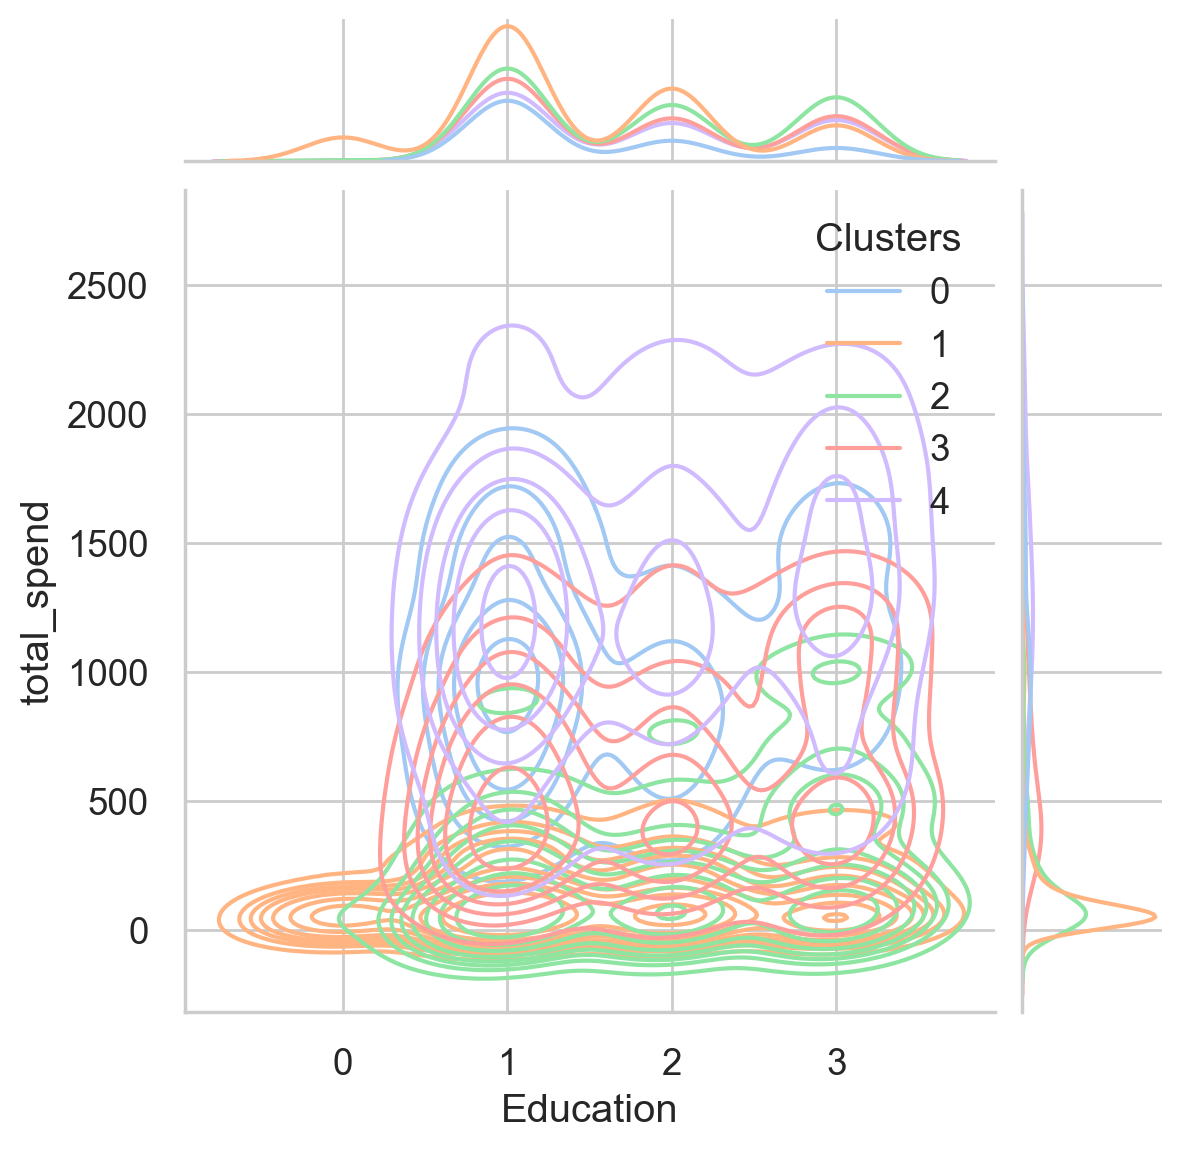

<Figure size 1200x800 with 0 Axes>

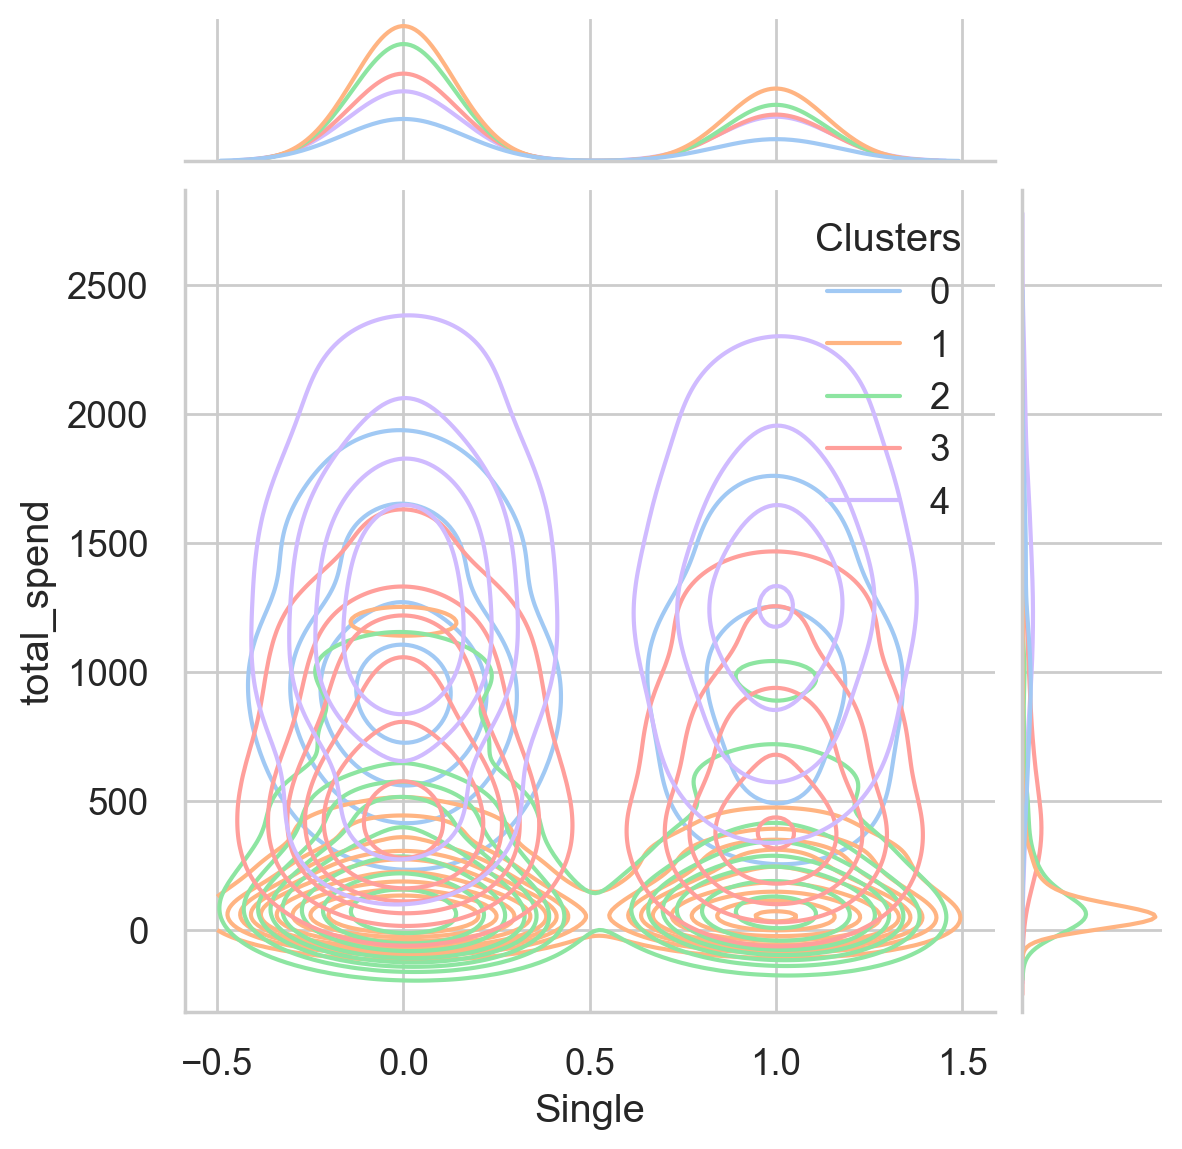

<Figure size 1200x800 with 0 Axes>

Cluster 4 dominated by 0 values
Cluster 2 dominated by 1 values
Cluster 3 dominated by 1 values
Cluster 0 dominated by 1 values


<Figure size 1200x800 with 0 Axes>

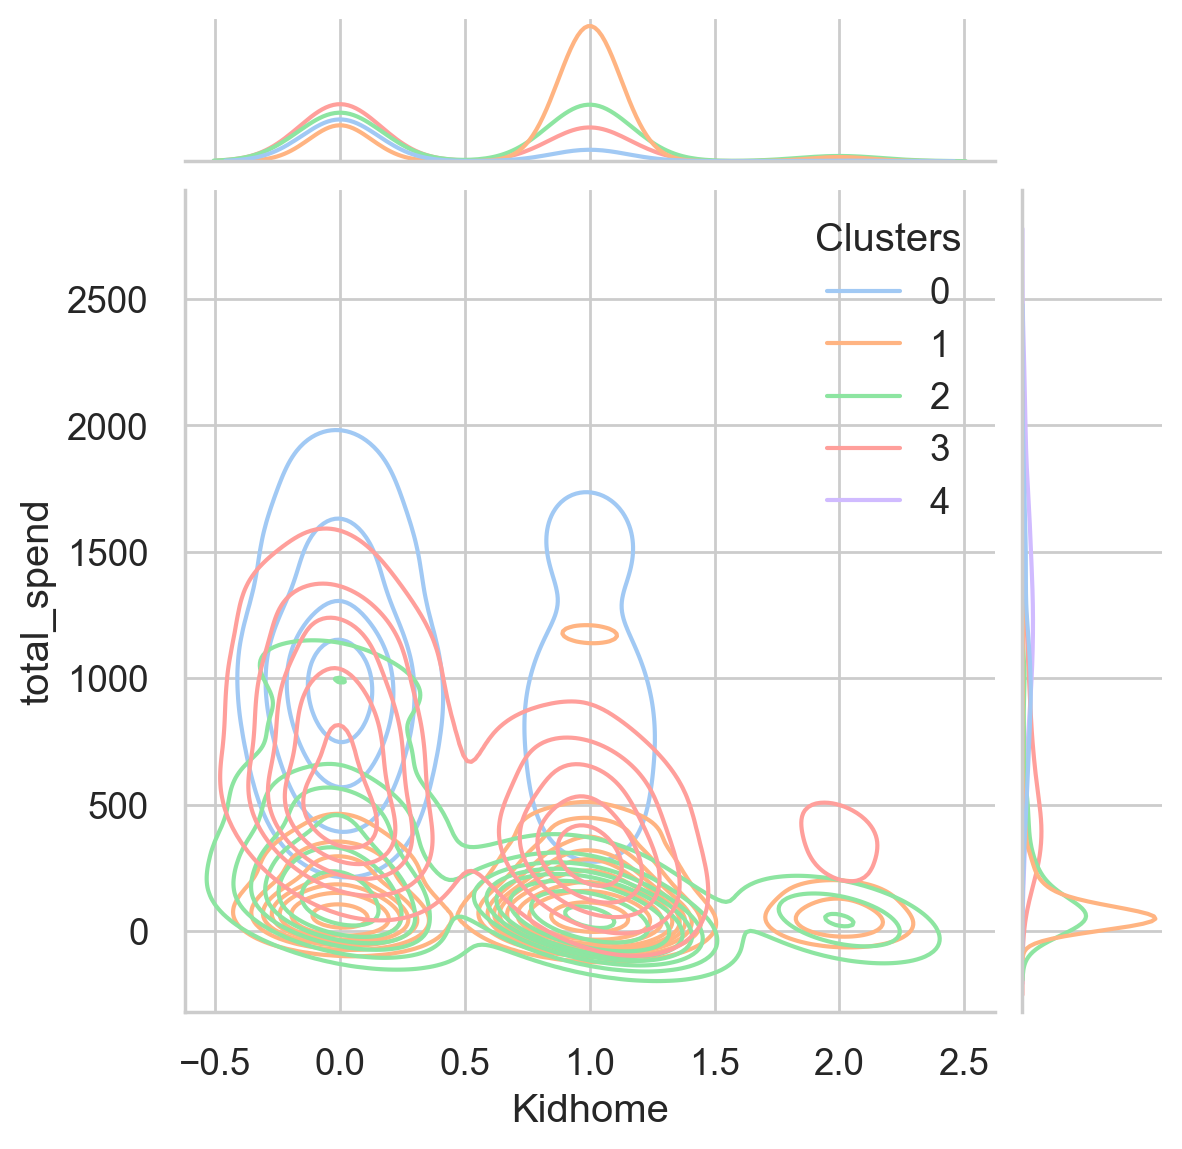

Cluster 4 dominated by 0 values


<Figure size 1200x800 with 0 Axes>

Cluster 4 dominated by 0 values
Cluster 2 dominated by 1 values
Cluster 1 dominated by 0 values


<Figure size 1200x800 with 0 Axes>

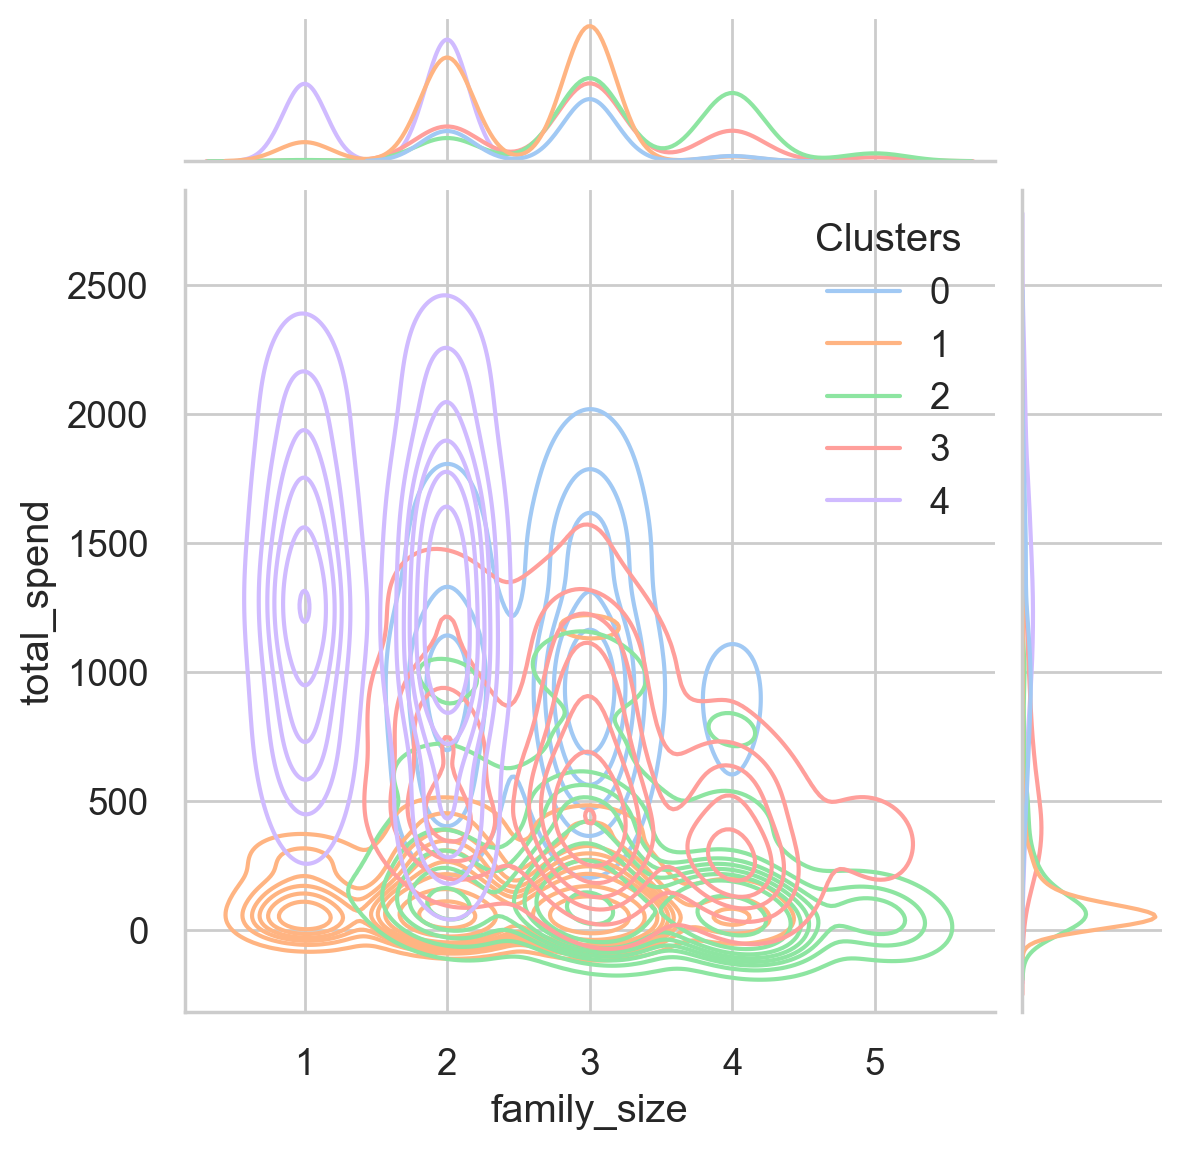

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

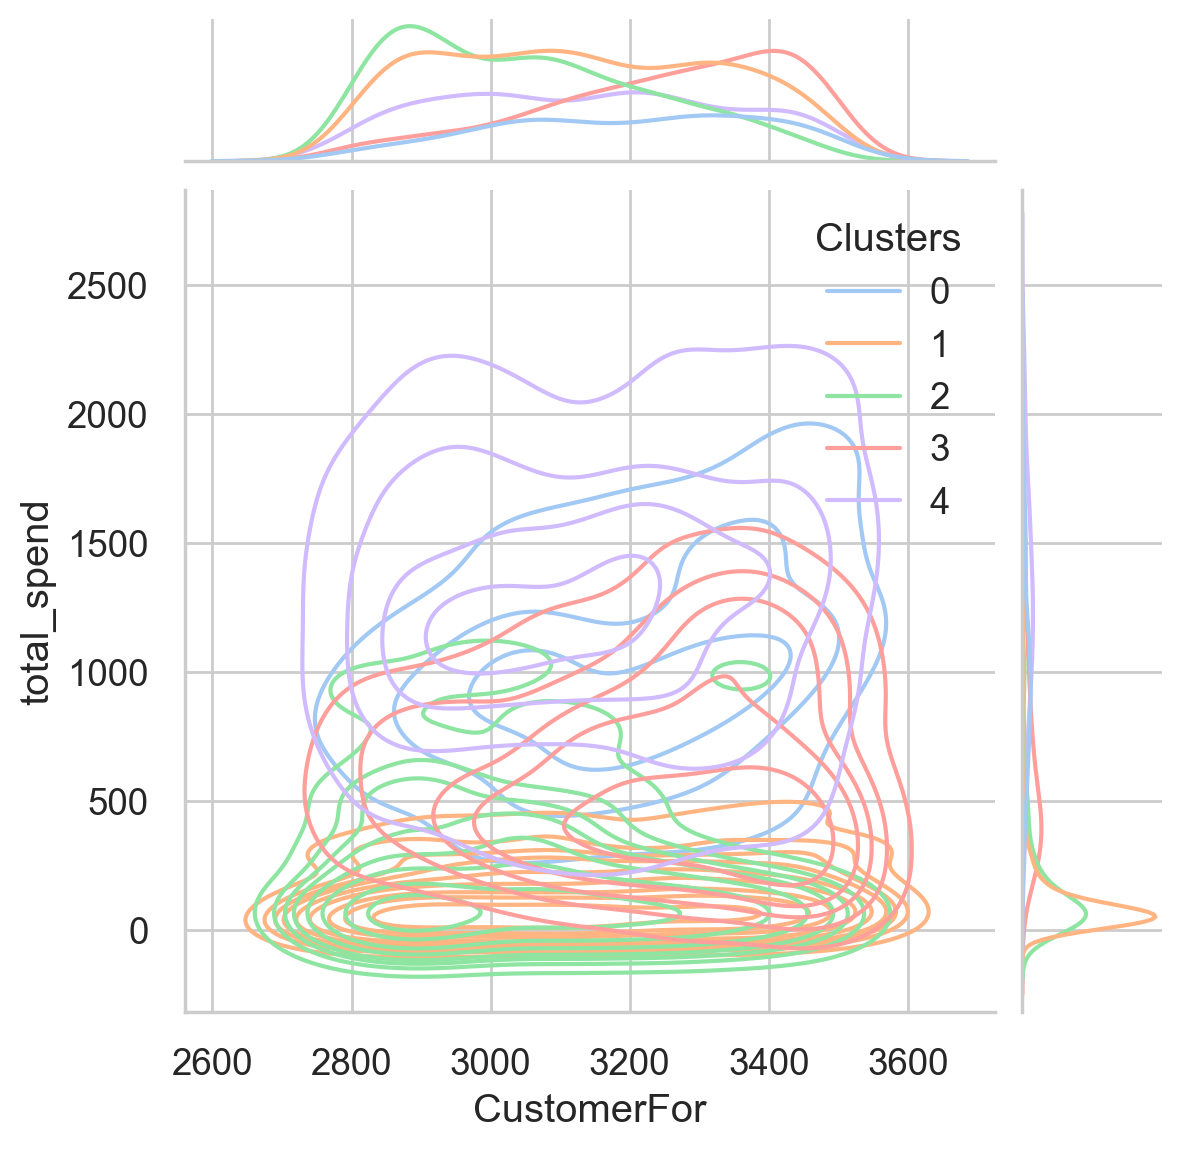

In [48]:
customers_profile = ["Education", "Single", "is_parent", "Kidhome", "Teenhome", "family_size", 'Age', "CustomerFor"]

for i in customers_profile:
    plt.figure()
    sns.jointplot(x=data[i], y=data["total_spend"], hue=data["Clusters"], kind="kde", palette='pastel')
    plt.show()
    for a in data.Clusters.unique():
        dominant_cluster(data, i,"Clusters", a, threshold=0.9)    

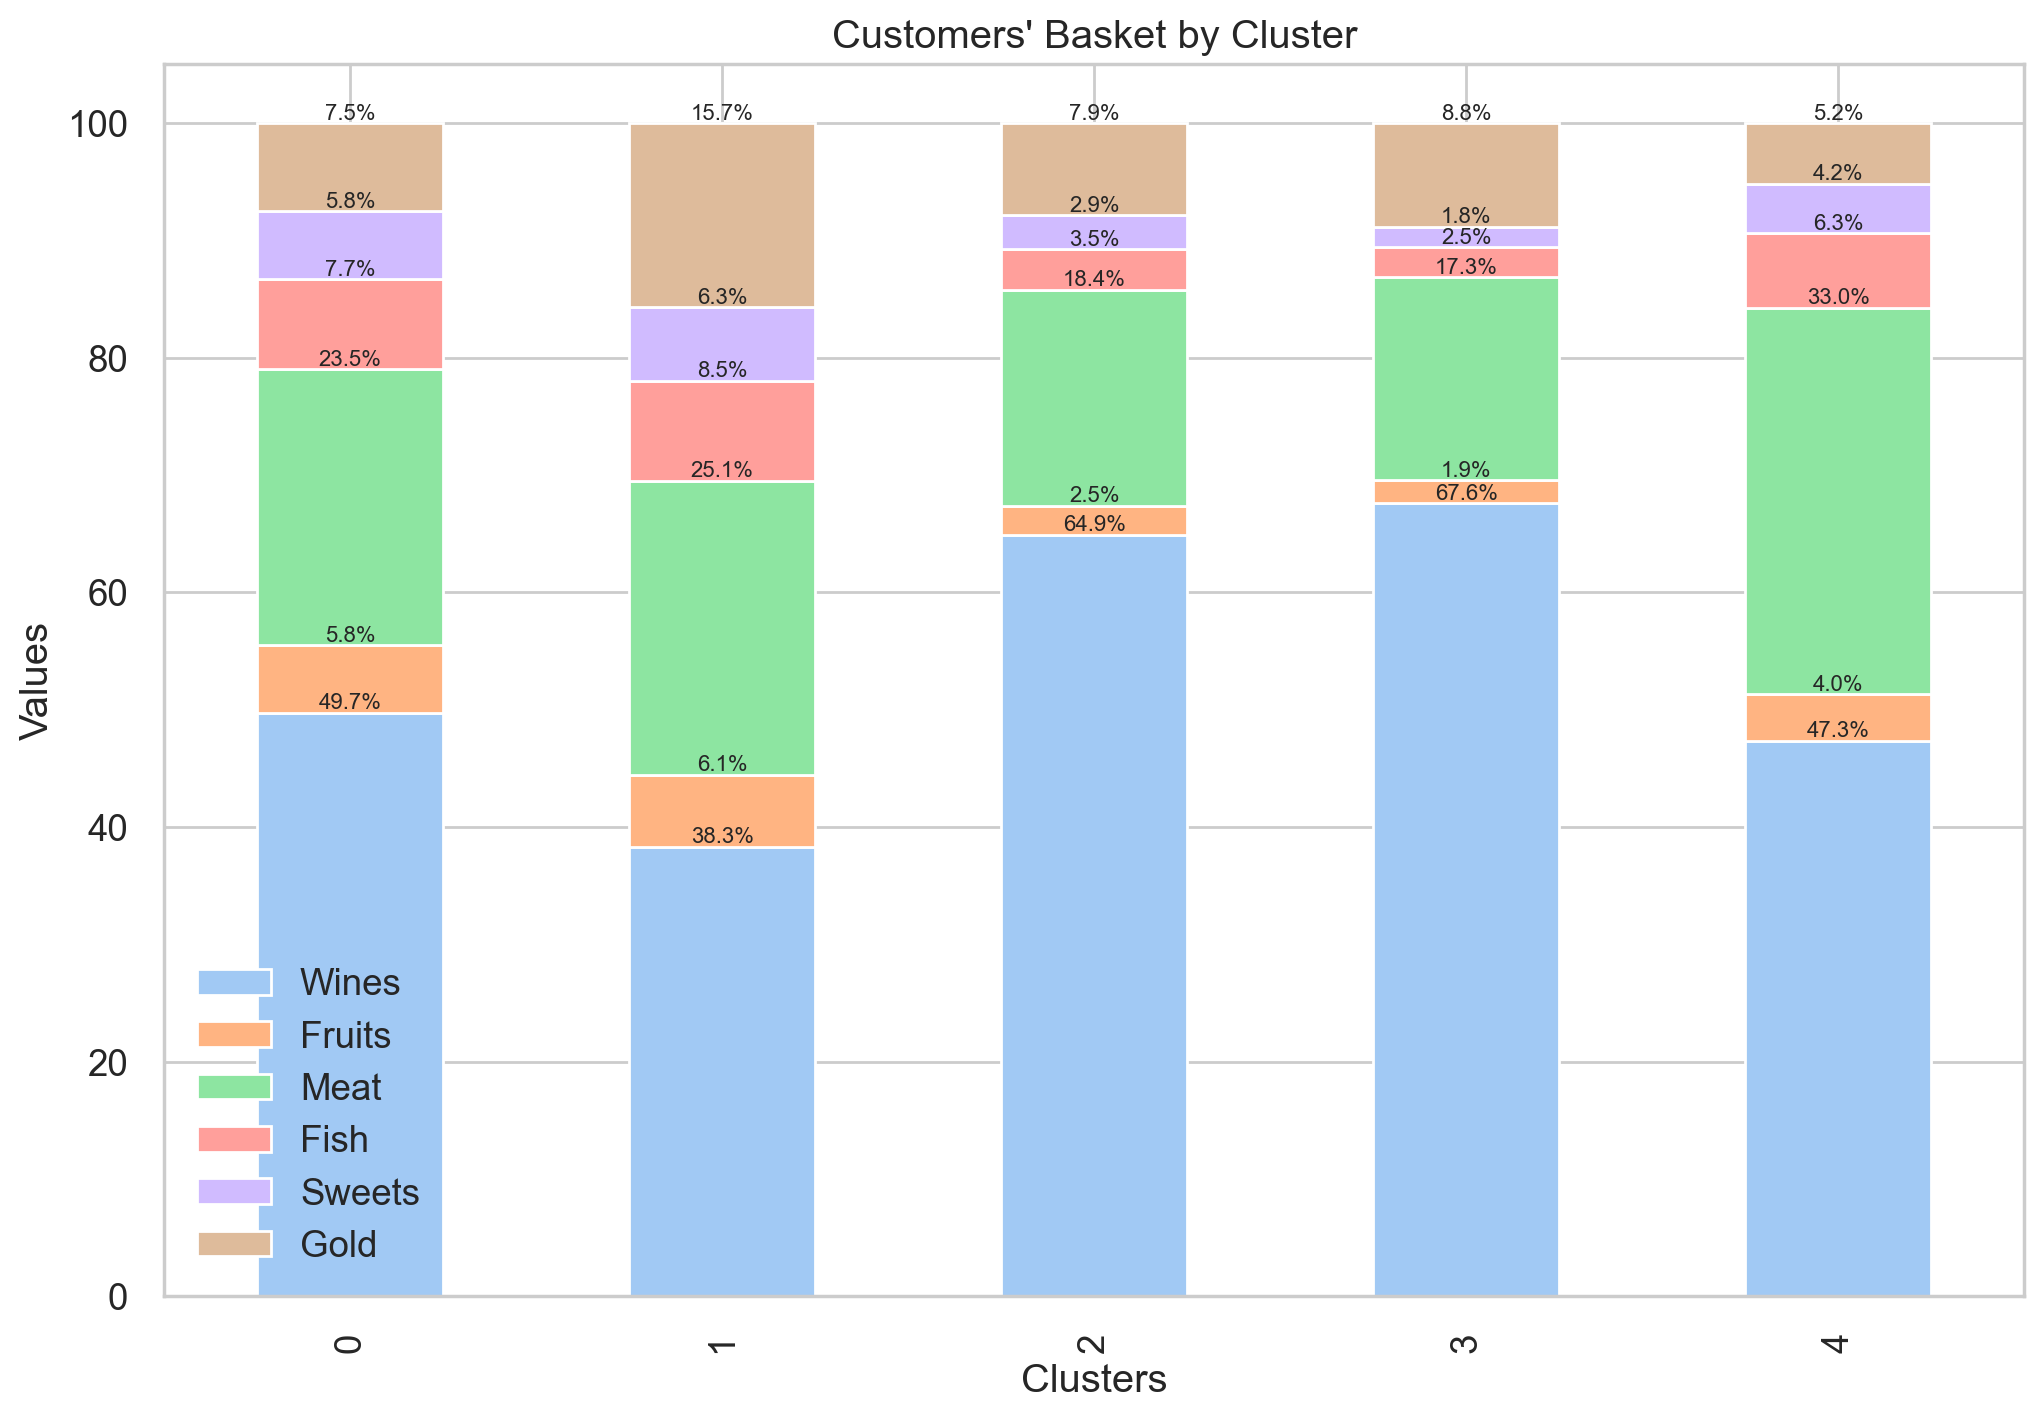

In [42]:
grouped = data.groupby("Clusters")["Wines", "Fruits", "Meat", "Fish", "Sweets", "Gold"].sum()

# divide each value by the sum of values in the same cluster and multiply by 100 to get the percentage
grouped_pct = grouped.apply(lambda x: 100 * x / float(x.sum()), axis=1)

# create a stacked bar chart with both percentage and actual values displayed
ax = grouped_pct.plot(kind='bar', stacked=True)
for i in ax.containers:
    ax.bar_label(i, label_type='edge', labels=[f"{x:.1f}%" if x>1 else f"{x:.2f}" for x in i.datavalues], fontsize=8)

# add chart title and axis labels
plt.title("Customers' Basket by Cluster")
plt.xlabel('Clusters')
plt.ylabel('Values')

# show the chart
plt.show()

In [43]:
ax = sns.countplot(x='Clusters', data=data)
ax.bar_label(ax.containers[0])
plt.show()

# Customer Segmentation
C0: 
- Having the least portion of customers 
- Have high purchasing power 
- Definitely, a parent who has a family size of around 2-3 people (the majority is 3 people)

C1: 
- The largest customer group
- Purchasing power is the least
- Most have a Graduation education level
- The majority are single and parent (single mom or dad) with the age of 30-50 years
- Have a family size of 2-3 people
- Their child likely to be kids than teen 

C2:
- Slightly low Income and spending compared with the median 
- Majority is Single
- 90% is a parents with a family size of 3-4  
- Their child likely to be teen t
- Age around 50-70 years
- Likely to be new customers

C3:
- Slightly high Income and spending compared with the median 
- Is a parent with a family size of 2-3 people
- The most used discount 
- Customer for a long time 
- The majority age is around 50-60 years
- In their basket, wine the largest portion compare with other groups

C4: 
- Highest purchasing power
- Definitely not a parent and has no kid or teen
- Family size only 1-2 people
- Have the most chance to accept a marketing campaign
- In their basket, meats are the largest portion compared with others.
  
